In [1]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit_machine_learning.algorithms import VQC
from qiskit.opflow import PauliSumOp

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

seed = 1376
algorithm_globals.random_seed = seed

In [2]:
data = load_wine()

X = pd.DataFrame(data.data, columns=data.feature_names)

Y = pd.DataFrame(data.target)

In [3]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [23]:
Y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [4]:
X.shape

(178, 13)

In [5]:
Y.shape

(178, 1)

## Select best predictors

In [6]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

In [7]:
scores = fit.scores_

In [8]:
combined = dict(zip(data.feature_names[:6], scores[:6]))
combined = dict(sorted(combined.items(), key=lambda x:x[1], reverse=True))

json_object = json.dumps(combined, indent = 4) 
print(json_object)

{
    "magnesium": 45.02638086789583,
    "alcalinity_of_ash": 29.383695485795723,
    "malic_acid": 28.068604567158005,
    "total_phenols": 15.623075898380389,
    "alcohol": 5.445498824971958,
    "ash": 0.7433805981876216
}


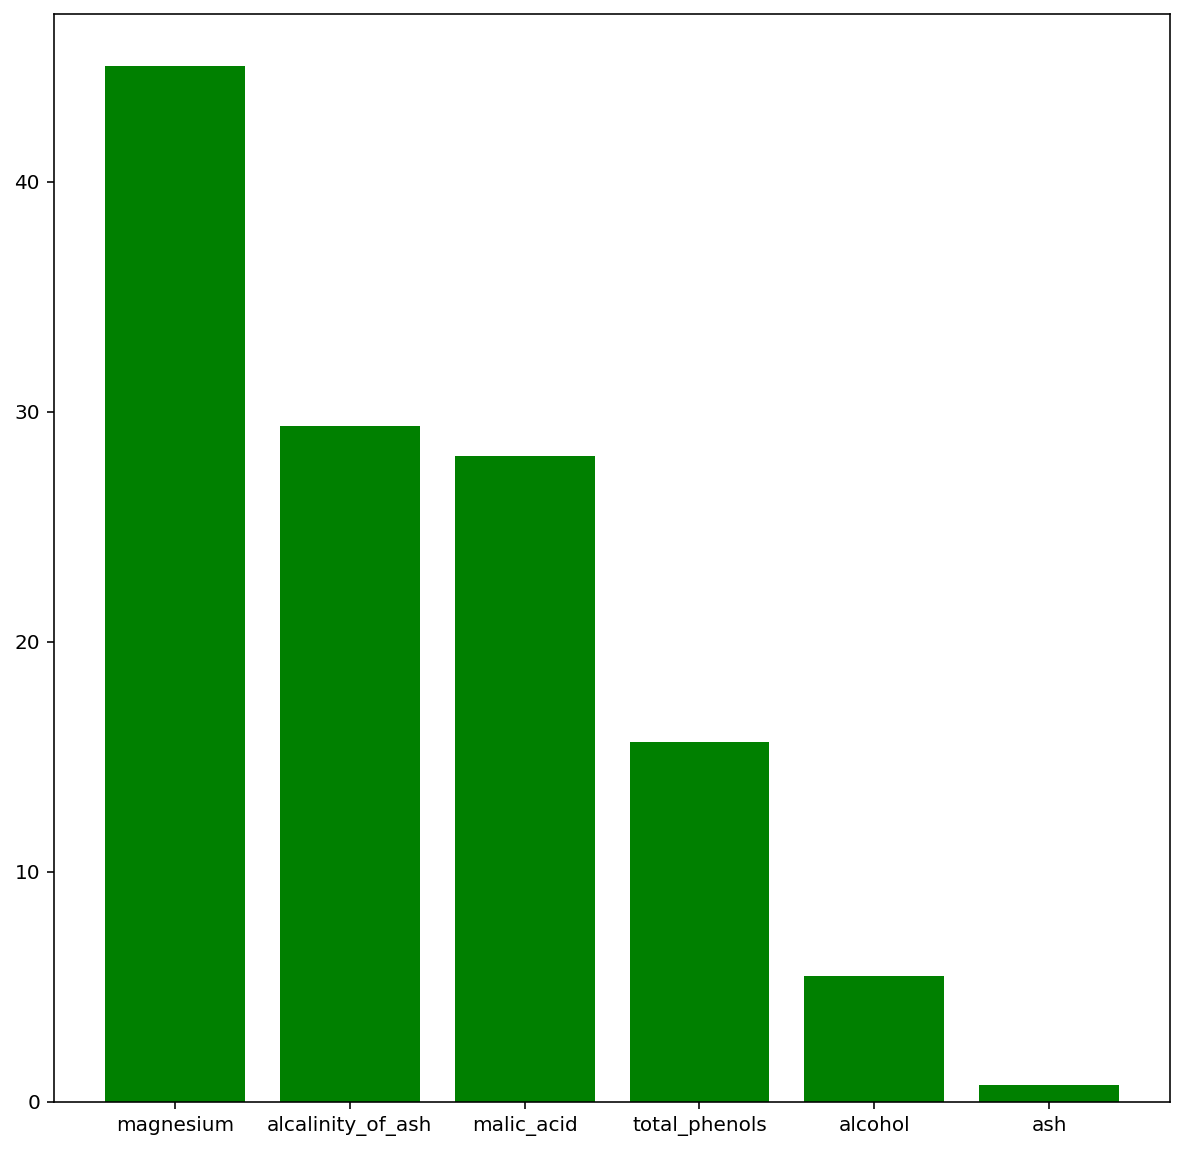

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.bar(combined.keys(), combined.values(), color='g')
plt.show()

In [10]:
X_data = X[['magnesium', 'alcalinity_of_ash', 'malic_acid', 'total_phenols']]
Y_data = Y

In [11]:
scaler_mm = MinMaxScaler()
X_data_temp = scaler_mm.fit_transform(X_data)
X_data_temp[:10]

array([[0.61956522, 0.25773196, 0.1916996 , 0.62758621],
       [0.32608696, 0.03092784, 0.2055336 , 0.57586207],
       [0.33695652, 0.41237113, 0.3201581 , 0.62758621],
       [0.4673913 , 0.31958763, 0.23913043, 0.98965517],
       [0.52173913, 0.53608247, 0.36561265, 0.62758621],
       [0.45652174, 0.2371134 , 0.20158103, 0.78965517],
       [0.2826087 , 0.20618557, 0.22332016, 0.52413793],
       [0.55434783, 0.36082474, 0.27865613, 0.55862069],
       [0.29347826, 0.17525773, 0.17786561, 0.62758621],
       [0.30434783, 0.27835052, 0.12055336, 0.68965517]])

In [12]:
Y_data = np.array(Y_data)
ohe_transformer = OneHotEncoder(sparse = False)
Y_data_temp = ohe_transformer.fit_transform(Y_data.reshape(-1,1))
Y_data_temp[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data_temp, Y_data_temp, test_size=0.2, random_state=seed)

In [14]:
feature_dim = X_data.shape[1]
feature_dim

4

In [15]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement="linear") # full

#ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)
ansatz = EfficientSU2(num_qubits = feature_map.num_qubits, reps = 4, entanglement = "full")

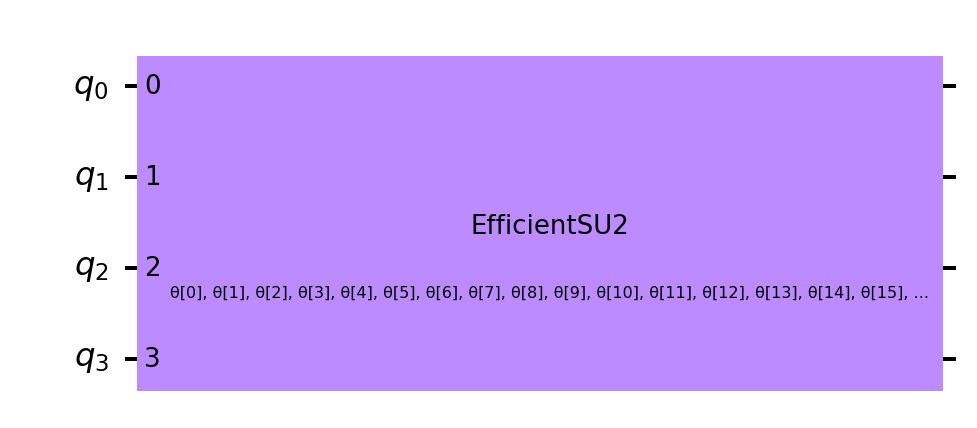

In [16]:
ansatz.draw('mpl')

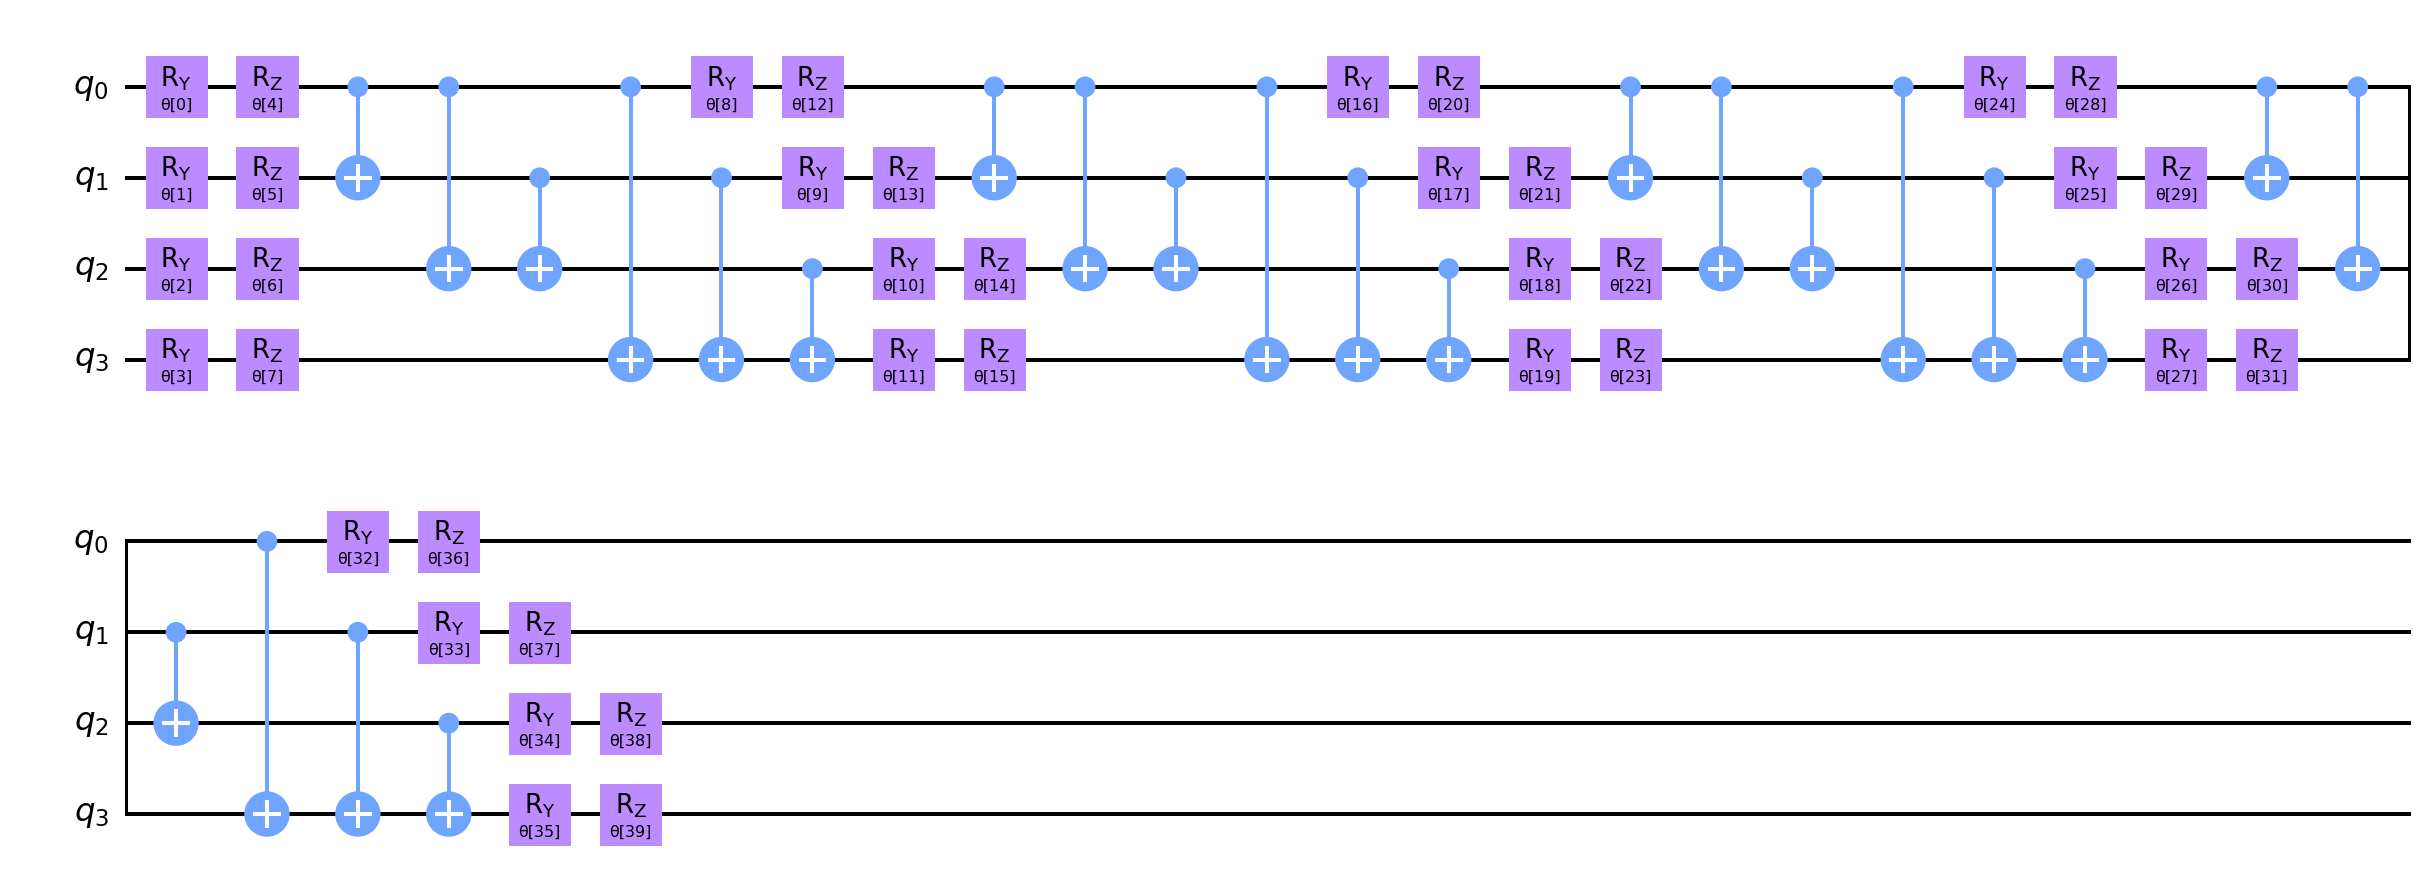

In [17]:
ansatz.decompose().draw('mpl')

In [18]:
device = BasicAer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(device, shots=1024, seed_simulator=seed, seed_transpiler=seed)

In [19]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [20]:
initial_point = algorithm_globals.random.random(ansatz.num_parameters)
optimizer = COBYLA(maxiter = 120, tol = 0.001)

vqc = VQC(feature_map=feature_map, 
          ansatz=ansatz, 
          optimizer=optimizer, 
          initial_point = initial_point,
          quantum_instance= quantum_instance,
          callback = callback_graph)

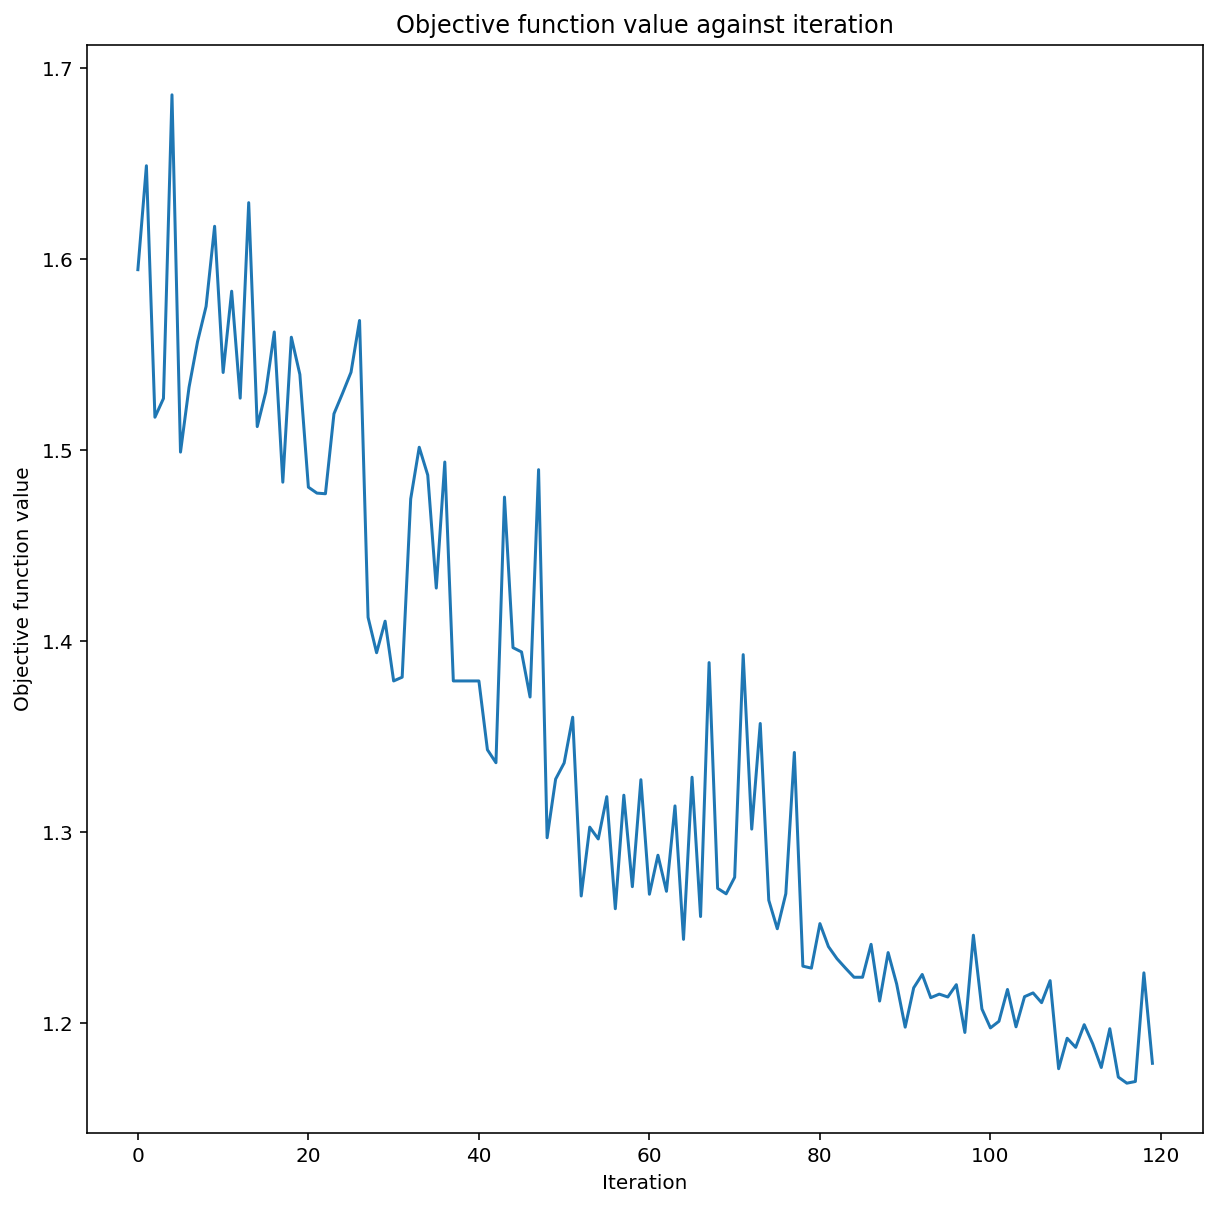

Time elapsed:  277.8784499168396


In [21]:
start = time.time()

objective_func_vals = []

vqc.fit(X_train, y_train)

elapsed = time.time() - start

print("Time elapsed: ", elapsed)

plt.show()

In [22]:
print("Train score: {:.2f} %".format(vqc.score(X_train, y_train)*100))
print("Test score: {:.2f} %".format(vqc.score(X_test, y_test)*100))

Train score: 69.01 %
Test score: 69.44 %
